In [2]:
from __future__ import print_function, division
%matplotlib inline

import sys, time, random, glob, os, pandas
import numpy as np
import librosa
import pydub
import matplotlib.pyplot as plt
from pydub import AudioSegment
from pydub import effects

import keras

from keras.utils import np_utils
from keras import optimizers
from keras.layers import Convolution2D, MaxPooling2D

import keras.models
from keras.losses import mse as kmse
import keras.backend as K
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Dropout, BatchNormalization, Activation, Flatten, Conv1D, Add, Multiply, Lambda, Conv2DTranspose, Concatenate, UpSampling2D, Reshape, Dot, Permute, RepeatVector
from keras.callbacks import LambdaCallback, EarlyStopping, ModelCheckpoint
from keras_self_attention import SeqSelfAttention

2023-06-20 11:25:06.024109: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-20 11:25:07.459120: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


##### Define Params
1. Copy stuff over from [common.py](common.py)

In [3]:
Fs = 48000 #! Sampling frequency
duration = 10 #! Miliseconds
n_fft = 4096 if Fs == 48000 else 2048 #! Fourier hehe
hop_length = int(Fs*0.025) # ~20 ms 24000*0.025
win_length = n_fft
n_mels = 96


In [10]:
import numpy as np
import librosa
import pydub

from pydub import AudioSegment
from pydub import effects

# ==================================
def cal_midpoints (dataObj) :

    data = dataObj.get_array_of_samples()    
    data = np.array(data)
    Fs = dataObj.frame_rate

    length     = len(data)
    step       = int(Fs*0.025) # 25ms
    window     = int(Fs*1.000) # 1.0s
    
    if dataObj.duration_seconds < 100 :
        return []

    start_idx = 0
    stop_idx  = window
    range_    = int((length-window)/step)
    print(range_)
    mag = []
    for i in range(range_):
        if i < 100  or i > (range_ - 10):
            mag.append(0)
        else:
            mag.append(np.sum(abs(data[start_idx:stop_idx])))
        start_idx += step
        stop_idx += step

    min_mag = min(mag[1800:4200])
    max_mag = max(mag[1800:4200])
    th = 0.50*(max_mag - min_mag) + min_mag

    mag_dsc = np.logical_xor(mag[:-1]>th, mag[1:]<th)

    dsc_list = np.argwhere(mag_dsc == False).flatten().tolist()

    last = len(dsc_list)
    tmp = []
    if last%2 == 0 and last <= 10:  # Even number of pairs
        for j in range(int(last/2)):
            if (dsc_list[2*j+1] - dsc_list[2*j]) > 20:
                tmp.append(dsc_list[2*j])
                tmp.append(dsc_list[2*j+1])
    else :
        tmp = dsc_list

    dsc_list = tmp

    last = len(dsc_list)

    midpoints = []
    
    prev_idx = 0
    for j in range(int(last/2)):
        idx = int((dsc_list[2*j] + dsc_list[2*j+1])/2)
        
        diff = step*(idx - prev_idx)/Fs
        if (j == 0) :
            if (diff < 35) or (diff > 105) :
                print ("distance error", j, diff)
                return midpoints
        elif ((diff < 9) or (diff > 16)):
            print ("distance error", j, diff)
            return midpoints
            
        prev_idx = idx
        
    for j in range(int(last/2)):
        midpoints.append(int((dsc_list[2*j] + dsc_list[2*j+1])/2))

    return midpoints


# ==================================
def gen_mel_feature (data, Fs, n_fft, hop_length, win_length, n_mels, log=True) :
    # We should keep power of two for n_fft
    # Fs is 48000, 20 ms is 48*20 = 960
    # Window is 48*50 = 2400
    # fft_step   = 20.0/1000.  # 20ms
    # fft_window = 50.0/1000.  # 50ms
    spectra_abs_min = 0.01 # From Google paper, seems justified

    melspectra = librosa.feature.melspectrogram(y=data, sr=Fs, n_fft=n_fft, hop_length=hop_length, 
                                         win_length=win_length, window='hann', n_mels=n_mels)
    if log :
        mel_log = np.log( np.maximum(spectra_abs_min, melspectra ))
    else :
        mel_log  = melspectra
    mel_log = mel_log.T
    return mel_log
from typing import List
from tensorblur.gaussian import GaussianBlur


def read_data (dataObj:pydub.audio_segment, midPoint:List[int], data_list: List,
               duration:int = 10, n_fft:int = 4096, n_mels:int = 96, blur:bool = False, blur_size:int = None) -> List[np.ndarray]:
    data = dataObj.get_array_of_samples() 
    data = np.array(data)
    max_data = 32768 #np.max(np.abs(data))

    Fs      = dataObj.frame_rate
    step    = int(Fs*0.025) # 25ms
    hop_length = step
    win_length = n_fft
    for idx in midPoint:
        for j in range(4) :
            i = random.randrange(0,10)

            start_idx = int(step*idx + Fs/4) - int((duration/2 + 0.034*i)*Fs)
            stop_idx  = start_idx + int(duration*Fs)
            mel_feature = gen_mel_feature (data [start_idx:stop_idx]/max_data, Fs, n_fft, hop_length, win_length, n_mels)
            if (blur):
                blur = GaussianBlur(size=blur_size)
                # mel_feature = np.array(mel_feature)
                mel_feature = np.expand_dims(mel_feature, 2)
                mel_feature = blur.apply(mel_feature)
                mel_feature = np.array(mel_feature) #from eager tensor to np array
                mel_feature = np.squeeze(mel_feature, 2)
            data_list.append(mel_feature)

    return data_list

##### PyDUB Testing


In [11]:
import pydub
never_gon = pydub.AudioSegment.from_file("/home/juggernautjha/Desktop/to_rahul/maruti/data/NG/11-May-2022_11-56-02-779_GPIO_MANUAL_TRIGGER_1_ATR.flac")

In [6]:
never_gon.set_frame_rate(Fs)

In [7]:
cal_midpoints(never_gon)

5159


[2332, 2802, 3284, 3785]

In [20]:
mydata = read_data(never_gon, cal_midpoints(never_gon), [], blur=True, blur_size=121)

5159


In [9]:
blur = GaussianBlur(size=7)
                # mel_feature = np.array(mel_feature)
p = np.stack([mydata[0], mydata[0], mydata[0]])
p = p.reshape(401, 96, 3)
mel_feature = blur.apply(p)
mel_feature=np.array(mel_feature)

2023-06-20 11:25:25.028867: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-20 11:25:25.169618: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


InvalidArgumentError: {{function_node __wrapped__DepthwiseConv2dNative_device_/job:localhost/replica:0/task:0/device:CPU:0}} input and filter must have the same depth: 3 vs 1 [Op:DepthwiseConv2dNative]

In [105]:
mel_feature.reshape(3, 401, 96)

array([[[-0.08956707,  0.02027452, -0.34235612, ..., -1.781164  ,
         -1.7487669 , -1.9395114 ],
        [-1.2455971 , -1.1273458 , -1.4381008 , ..., -1.7509528 ,
         -1.7190363 , -1.9213383 ],
        [-1.3142626 , -1.1583972 , -1.4690689 , ..., -1.7635055 ,
         -1.7730172 , -1.7895235 ],
        ...,
        [-2.1377075 , -1.8552096 , -2.6363332 , ..., -3.4305212 ,
         -3.4588342 , -3.522735  ],
        [ 0.23511234,  0.47143367, -0.38770548, ..., -3.3876746 ,
         -3.364578  , -3.81681   ],
        [-2.4104943 , -2.2002764 , -2.8797145 , ..., -3.3639748 ,
         -3.3157547 , -3.7849624 ]],

       [[-2.245911  , -1.9958509 , -2.7380083 , ..., -3.4432423 ,
         -3.4585655 , -3.5284054 ],
        [ 0.06007717,  0.30222145, -0.44630703, ..., -3.453286  ,
         -3.4148102 , -3.853011  ],
        [-2.562182  , -2.324339  , -2.96741   , ..., -3.42567   ,
         -3.3855553 , -3.8497286 ],
        ...,
        [-2.1377075 , -1.8552096 , -2.6363332 , ..., -

In [107]:
mel_feature[1] == mel_feature[0]

array([[False, False, False],
       [False, False, False],
       [False, False, False],
       [False, False, False],
       [False, False, False],
       [False, False, False],
       [False, False, False],
       [False, False, False],
       [False, False, False],
       [False, False, False],
       [False, False, False],
       [False, False, False],
       [False, False, False],
       [False, False, False],
       [False, False, False],
       [False, False, False],
       [False, False, False],
       [False, False, False],
       [False, False, False],
       [False, False, False],
       [False, False, False],
       [False, False, False],
       [False, False, False],
       [False, False, False],
       [False, False, False],
       [False, False, False],
       [False, False, False],
       [False, False, False],
       [False, False, False],
       [False, False, False],
       [False, False, False],
       [False, False, False],
       [False, False, False],
       [Fa

In [92]:
p.shape

(401, 96, 1)

In [84]:
m = np.array([mydata[0]]).

In [85]:
m.shape

(1, 401, 96)

##### Write Generators
I have no clue why I am doing this, maybe to gain a better understanding

[Text(0.5, 1.0, 'Mel-frequency spectrogram')]

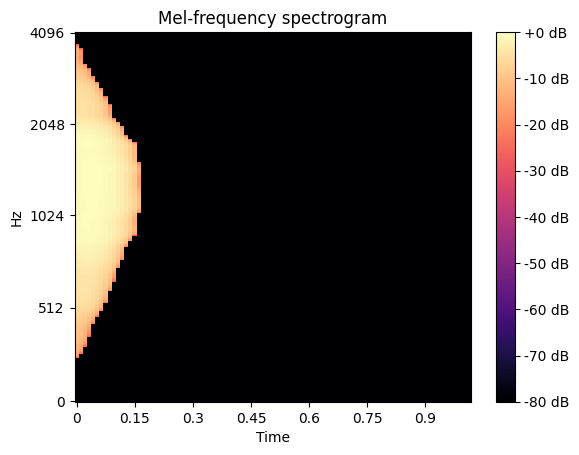

In [21]:
fig, ax = plt.subplots()
S_dB = librosa.power_to_db(mydata[0], ref = np.max)
img = librosa.display.specshow(S_dB, x_axis='time', y_axis='mel', sr=Fs, 
                               fmax=4096, ax = ax)
fig.colorbar(img, ax=ax, format='%+2.0f dB')
ax.set(title='Mel-frequency spectrogram')

[Text(0.5, 1.0, 'Mel-frequency spectrogram')]

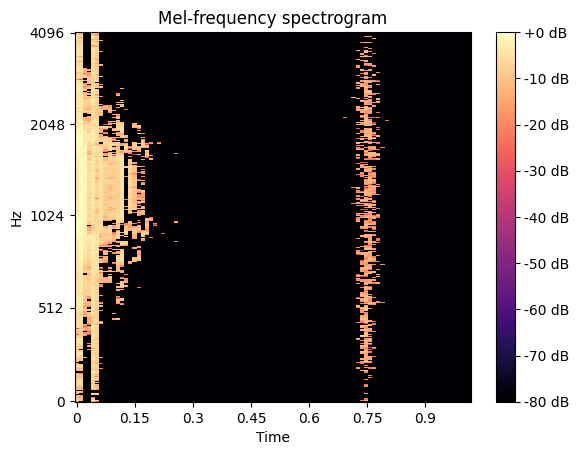

In [70]:
fig, ax = plt.subplots()
S_dB = librosa.power_to_db(mel_feature, ref = np.max)
img = librosa.display.specshow(S_dB, x_axis='time', y_axis='mel', sr=Fs, 
                               fmax=4096, ax = ax)
fig.colorbar(img, ax=ax, format='%+2.0f dB')
ax.set(title='Mel-frequency spectrogram')


In [56]:
img.to_rgba()


(0.987053, 0.991438, 0.749504, 1.0)

In [32]:
S_dB

array([[[-1.55962270e-01, -2.24899021e-01, -3.32988659e-01, ...,
         -3.15837248e-01, -2.77785336e-01,  0.00000000e+00],
        [-1.79586053e-01, -2.49458720e-01, -3.57188121e-01, ...,
         -3.41525249e-01, -3.03966347e-01, -2.15356414e-02],
        [-2.37531159e-01, -3.09358144e-01, -4.16918889e-01, ...,
         -4.03842834e-01, -3.66997054e-01, -7.51531998e-02],
        ...,
        [-1.18689305e+01, -1.43014239e+01, -8.00000000e+01, ...,
         -1.50558584e+01, -8.00000000e+01, -8.00000000e+01],
        [-1.82039225e+01, -1.42367450e+01, -1.56826225e+01, ...,
         -8.00000000e+01, -8.00000000e+01, -2.74088000e+01],
        [-1.49969738e+01, -1.08487022e+01, -1.75118624e+01, ...,
         -8.00000000e+01, -8.00000000e+01, -8.00000000e+01]]])

In [33]:
img = librosa.display.specshow(S_dB[0], ax=ax)